# Toxic Comment Classifier

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# The data

First, we load the dataset of Wikipedia comments from the `data` folder. This dataset was obtained from [Toxic Comment Classification Challenge](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data) Kaggle competition. Each row contains the comment text and labels for toxic behavior: `toxic`, `severe_toxic`, `obscene`, `threat`, `insult` and `identity_hate`.
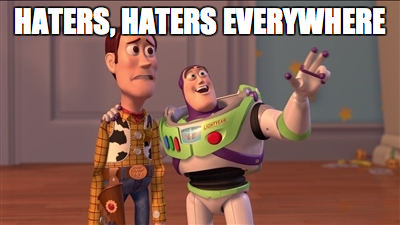

In [ ]:
import os

# We limit the number of rows loaded from the dataset to speed up training time
NROWS = 5000

tutorial_dir_path = os.path.dirname(os.path.abspath(os.getcwd()))
train_data_path = os.path.join(tutorial_dir_path, "data/train.csv")

train = pd.read_csv(train_data_path, nrows=NROWS)

Let's explore the data to visualize what it looks like and understand the distribution across the toxicity behaviors.

In [ ]:
print("Train data shape: ", train.shape)
# sample rows to visualize
train.head()

In [ ]:
sentence_lengths = [len(sentence) for sentence in train['comment_text']]
plt.hist(sentence_lengths,500)
plt.xlabel('Length of comments')
plt.show()

In [ ]:
feature = train.drop(['id', 'comment_text'], axis=1)     ### Removed unnecessary columns - id and comment_text
counts = []                                               ### A list that contains tuple which consists of class label and number of comments for that particular class 
categories = list(feature.columns.values)
for i in categories:
    counts.append((i, feature[i].sum()))
    
df_1 = pd.DataFrame(counts, columns=['Feature Labels', 'Total Comments'])   ### Dataframe made up of category and total number of comments
df_1.plot(x='Feature Labels', y='Total Comments', kind='bar', figsize=(8,8))
plt.title("Comments per category")
plt.ylabel('Total comments', fontsize=12)
plt.xlabel('Feature Labels', fontsize=12)

# Dataset split

In [ ]:
from sklearn.model_selection import train_test_split

X = train['comment_text']
y = train.iloc[:,2:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Preprocessing

We preprocess the text using these rules:

1. Remove special chars
2. Remove punctuation
3. Convert to lowercase
4. Replace numbers
5. Tokenize text
6. Remove stopwords
7. Lemmatize words

In [ ]:
from sklearn.base import BaseEstimator

class TextPreprocessor(BaseEstimator):
    """TextPreprocessor preprocesses text by applying these rules:
    
    - Remove special chars
    - Remove punctuation
    - Convert to lowercase
    - Replace numbers
    - Tokenize text
    - Remove stopwords
    - Lemmatize words
    
    It implements the BaseEstimator interface and can be used in sklearn pipelines.
    """
    
    def remove_special_chars(self, text):
        import re
        import html
        
        re1 = re.compile(r'  +')
        x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
            'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
            '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
            ' @-@ ', '-').replace('\\', ' \\ ')
        return re1.sub(' ', html.unescape(x1))
    
    def remove_punctuation(self, text):
        """Remove punctuation from list of tokenized words"""
        import string
        
        translator = str.maketrans('', '', string.punctuation)
        return text.translate(translator)

    def to_lowercase(self, text):
        return text.lower()

    def replace_numbers(self, text):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        import re
        
        return re.sub(r'\d+', '', text)
    
    def text2words(self, text):
        from nltk.tokenize import word_tokenize
        
        return word_tokenize(text)

    def remove_stopwords(self, words):
        """
        :param words:
        :type words:
        :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
        or
        from spacy.lang.en.stop_words import STOP_WORDS
        :type stop_words:
        :return:
        :rtype:
        """
        from nltk.corpus import stopwords
        stop_words = stopwords.words('english')
        
        return [word for word in words if word not in stop_words]

    def lemmatize_words(self, words):
        """Lemmatize words in text"""
        from nltk.stem import WordNetLemmatizer

        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word) for word in words]

    def lemmatize_verbs(self, words):
        """Lemmatize verbs in text"""
        from nltk.stem import WordNetLemmatizer

        lemmatizer = WordNetLemmatizer()
        return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

    def clean_text(self, text):
        text = self.remove_special_chars(text)
        text = self.remove_punctuation(text)
        text = self.to_lowercase(text)
        text = self.replace_numbers(text)
        words = self.text2words(text)
        words = self.remove_stopwords(words)
        words = self.lemmatize_words(words)
        words = self.lemmatize_verbs(words)

        return ''.join(words)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return map(lambda x: self.clean_text(x), X)

# Tracking experiment with MLflow

We use a mix of manual and automatic logging to record training runs with MLflow. `mlflow.sklearn.autolog` does the heavy lifting of tracking most metrics and parameters. We complement these metrics by logging some results manually.

**Important**: Because the [git commit sha is not automatically tracked](https://github.com/mlflow/mlflow/issues/973) by MLflow when logging data on Jupyter notebooks, we must log it manually as a workaround. This allows us to connect experiment results to the version of the code and data that generated it.

`MLflow run` -> `Git commit` -> `DVC data version`

In [ ]:
import mlflow

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Toxic Comment Classifier")
mlflow.sklearn.autolog(silent=True)

import git
repo = git.Repo(search_parent_directories=True)
sha_commit = repo.head.object.hexsha

# Training the models

We try three different approaches where we play with different vectorization methods: bag of words, TF-IDF and word2vec. The K-nearest-neighbors classifier remains the same for all three experiments. In summary:

* Bag of words + K-nearest-neighbors
* TF-IDF + K-nearest-neighbors
* Word2vec + K-nearest-neighbors

## Bag of words + K-nearest neighbors

In this approach, we use the [bag of words model](https://en.wikipedia.org/wiki/Bag-of-words_model) to generate a vector of features from each sentence in the dataset. These features are then passed to the [K-nearest neighbors classifier](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) which learns to predict the labels.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

p = Pipeline([
    ('preprocessing', TextPreprocessor()),
    ('bow', CountVectorizer(min_df=2, max_features=1000)),
    ('knn', KNeighborsClassifier(n_neighbors=6))
])

In [ ]:
mlflow.start_run()
mlflow.set_tag('mlflow.source.git.commit', sha_commit)
mlflow.set_tag('method', 'bag of words')

p.fit(X_train, y_train)
p.score(X_test, y_test)

mlflow.end_run()

## TF-IDF + K-nearest neighbors

In this approach, we use the [TF–IDF model](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) to generate a vector of features from each sentence in the dataset. These features are then passed to the [K-nearest neighbors classifier](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) which learns to predict the labels.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

p = Pipeline([
    ('preprocessing', TextPreprocessor()),
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_features=1000)),
    ('knn', KNeighborsClassifier(n_neighbors=6))
])

In [ ]:
mlflow.start_run()
mlflow.set_tag('mlflow.source.git.commit', sha_commit)
mlflow.set_tag('method', 'tfidf')

p.fit(X_train, y_train)
p.score(X_test, y_test)

mlflow.end_run()

## Word2vec + K-nearest neighbors

In this approach, we use the [Wor2vec model](https://en.wikipedia.org/wiki/Word2vec) to generate a vector of features from each sentence in the dataset. These features are then passed to the [K-nearest neighbors classifier](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) which learns to predict the labels.

In [ ]:
from sklearn.base import BaseEstimator
from gensim.models import Word2Vec

class Word2vecTransformer(BaseEstimator):
    """ Wor2vecTransformer provides a wrapper around gensim's Word2Vec model
    to be used in sklearn's pipeline.
    """
    
    def __init__(self, min_count=5, vector_size=100, window=5):
        self.min_count = min_count
        self.vector_size = vector_size
        self.window = window
        self.sentences = []
    
    def fit(self, x, y=None):
        self.sentences = list(map(lambda k: k.split(), x))
        
        self.model = Word2Vec(min_count=self.min_count, vector_size=self.vector_size, window=self.window, sg=1)
        self.model.build_vocab(self.sentences, progress_per=10000)
        self.model.train(self.sentences, total_examples=self.model.corpus_count, epochs=20)

        return self
    
    def transform(self, x):
        sentences = list(map(lambda k: k.split(), x))
        if len(sentences) != 0:
            self.sentences = sentences
        w2v_words = list(self.model.wv.index_to_key)
    
        # We calculate the sentence embedding as the average of the embedding of the words in the sentence
        vector = []
        for sentence in self.sentences:
            sentence_vec = np.zeros(self.vector_size)
            count = 0
            for word in sentence: 
                if word in w2v_words:
                    vec = self.model.wv[word]
                    sentence_vec += vec 
                    count += 1
            if count != 0:
                sentence_vec /= count # averaging
            vector.append(sentence_vec)
            
        return vector

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

p = Pipeline([
    ('preprocessing', TextPreprocessor()),
    ('word2vec', Word2vecTransformer()),
    ('knn', KNeighborsClassifier(n_neighbors=6))
])

In [ ]:
mlflow.start_run()
mlflow.set_tag('mlflow.source.git.commit', sha_commit)
mlflow.set_tag('method', 'word2vec')

p.fit(X_train, y_train)
p.score(X_test, y_test)

mlflow.end_run()

## Aknowledgement

This notebook was inspired by [[1]](https://www.kaggle.com/code/marimmedhat/nlp-v1/notebook) and [[2]](https://colab.research.google.com/github/ujjalkumarmaity/Twitter_Sentiment_Analysis/blob/master/Twitter_Sentiment_Analysis_word2vec.ipynb).